# Neural Networks Applied to Computer Vision/Image Recognition/Classification

Image recognition/Object Classification is one of the most popular and well researched field of Computer Vision. Mathematically acceptable methods are being rapidly developed to replicate real biological processes for automatic recognition of people, animals, stationary and moving objects as well as places. Many applications are available on smart phones, that can perform sophisticated image recognition task such as face recognition and etc.

This project aims to implement and compare different computer vision (CV)/machine learning (ML) algorithms which can train a computer to discriminate between different types of objects.

In [1]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.callbacks import CSVLogger
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical  # Updated import statement
from tensorflow.keras.models import load_model

from keras.datasets import cifar10
# from keras.utils.np_utils import to_categorical  # Remove this line

import random
np.random.seed(0)


We will implement the following algorithmic pipeline to solve this problem
1.	Read/Load a set of raw images from the CIFAR10 public dataset. The dataset can easily be downloaded from Internet. You can download and save the dataset in your hard drive and later work on it if you are using a local installation of Python such as Anaconda. However, if you prefer to use Google Colab, you can download it at the runtime, or else copy it to your google drive and mount your drive in the google Colab.  
2.	Extract best possible features from the raw images using classical computer vision techniques. More specifically, you are advised to use the combinations of Feature Detectors/Descriptors, as described in the assignment handout.




Load the relevant dataset

In [79]:
import cv2
import numpy as np
from keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from skimage.feature import hog

# Load CIFAR-10 dataset
(X_train_raw, y_train_all), (X_test_raw, y_test_all) = cifar10.load_data()

# Select a subset of the dataset for demonstration purposes
X_train_new = X_train_raw[0:500]
X_test_new = X_test_raw[0:500]
y_train = y_train_all[0:500]
y_test = y_test_all[0:500]

# Function to extract Harris corner and HOG features
def extract_features(img):
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Harris corner detection
    harris_corners = cv2.cornerHarris(gray, 2, 3, 0.04)
    harris_corners = cv2.dilate(harris_corners, None)

    # HOG feature extraction
    hog_features, _ = hog(gray, visualize=True)
    size = int(np.sqrt(hog_features.size))

    # Resize Harris corner to match HOG dimensions
    harris_corners_resized = cv2.resize(harris_corners, (size, size))

    # Reshape HOG features to (x, y, 1)
    hog_features = hog_features.reshape((size, size, 1))

    # Combine Harris corner and HOG features
    combined_features = np.concatenate([harris_corners_resized[:, :, np.newaxis], hog_features], axis=-1)

    return combined_features

# Apply feature extraction to each image in the dataset
X_train = np.array([extract_features(img) for img in X_train_new])
X_test = np.array([extract_features(img) for img in X_test_new])

# Print the shapes before and after feature extraction
print("Before Feature Extraction:")
print(X_train_new.shape)
print(X_test_new.shape)

print("\nAfter Combined Feature Extraction:")
print(X_train.shape)
print(X_test.shape)


Before Feature Extraction:
(500, 32, 32, 3)
(500, 32, 32, 3)

After Combined Feature Extraction:
(500, 18, 18, 2)
(500, 18, 18, 2)


Please note that the you code above may download the data in the raw format, i.e, raw images of (rows x columns) size each.

As exlplained in the assignment houndout, you are requried to extract the best possible features from the raw images using classical computer vision techniques

In [51]:
# X_train = X_train_all[0:500]
# y_train = y_train_all[0:500]
# X_test = X_test_all[0:500]
# y_test = y_test_all[0:500]
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)



(500, 18, 18, 2)
(500, 18, 18, 2)
(500, 1)
(500, 1)


In [80]:
np.shape(X_train)[2]


18

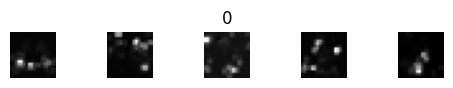

In [82]:

num_of_samples = []
cols = 5
num_classes = 10
fig, axs = plt.subplots(nrows=1, ncols=cols, figsize=(5, 2))
fig.tight_layout()

for i in range(cols):
    for j in range(num_classes):
        # Use np.argmax to find the indices where y_train equals j
        indices = np.where(np.argmax(y_train, axis=1) == j)[0]

        # Check if indices is not empty
        if indices.size > 0:
            # Randomly select an index from the matching indices
            random_index = random.choice(indices)

            # Display a single channel from the combined features
            axs[i].imshow(X_train[random_index, :, :, 0], cmap='gray')  # Adjust the channel index if needed
            axs[i].axis("off")

            if i == 2:
                axs[i].set_title(str(j))
                num_of_samples.append(len(indices))

plt.show()
# num_of_samples = []
# cols = 5
# num_classes = 10
# fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5, 8))
# fig.tight_layout()

# img_shape = (32, 32, 3)  # Replace 3 with the actual number of channels

# for i in range(cols):
#     for j in range(num_classes):
#         x_selected = X_train[y_train.reshape(-1) == j]
#         random_index = random.randint(0, len(x_selected) - 1)
#         img = x_selected[random_index].reshape(*img_shape)
#         axs[j][i].imshow(img, cmap=plt.get_cmap("gray"))
#         axs[j][i].axis("off")

#         if i == 2:
#             axs[j][i].set_title(str(j))
#             num_of_samples.append(len(x_selected))

# plt.show()


[500]


Text(0, 0.5, 'Number of images')

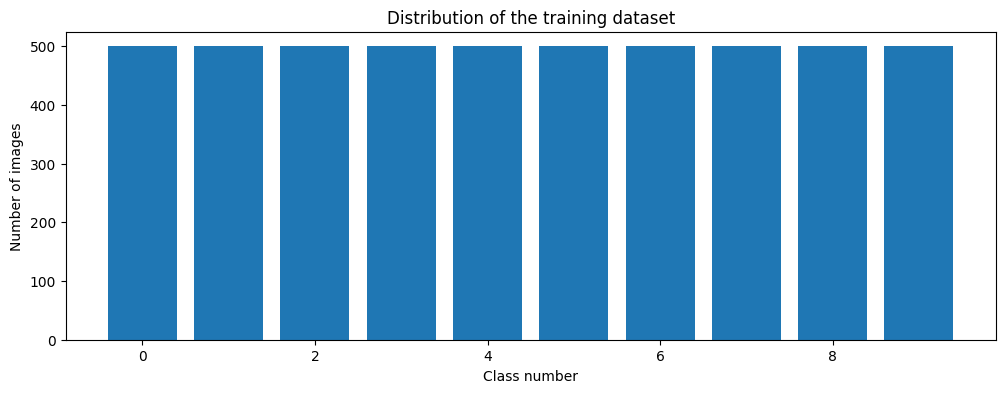

In [55]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")

In [56]:
print(type(y_train[0]))
y_train= to_categorical(y_train,10)
y_train[0]
# y_test = to_categorical(y_test,10)

<class 'numpy.ndarray'>


array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.], dtype=float32)

In [57]:
X_train=X_train/255
X_test= X_test/255

In [58]:
np.shape(X_train)

(500, 18, 18, 2)

In [59]:
#28x28=784
num_pixels = np.shape(X_train)[1] * np.shape(X_train)[2] * np.shape(X_train)[3]
X_train = X_train.reshape(X_train.shape[0], num_pixels)
X_test = X_test.reshape(X_test.shape[0], num_pixels)




In [60]:
print(X_train.shape)
print(X_test.shape)

(500, 648)
(500, 648)


#Builtin ANN Model for Reference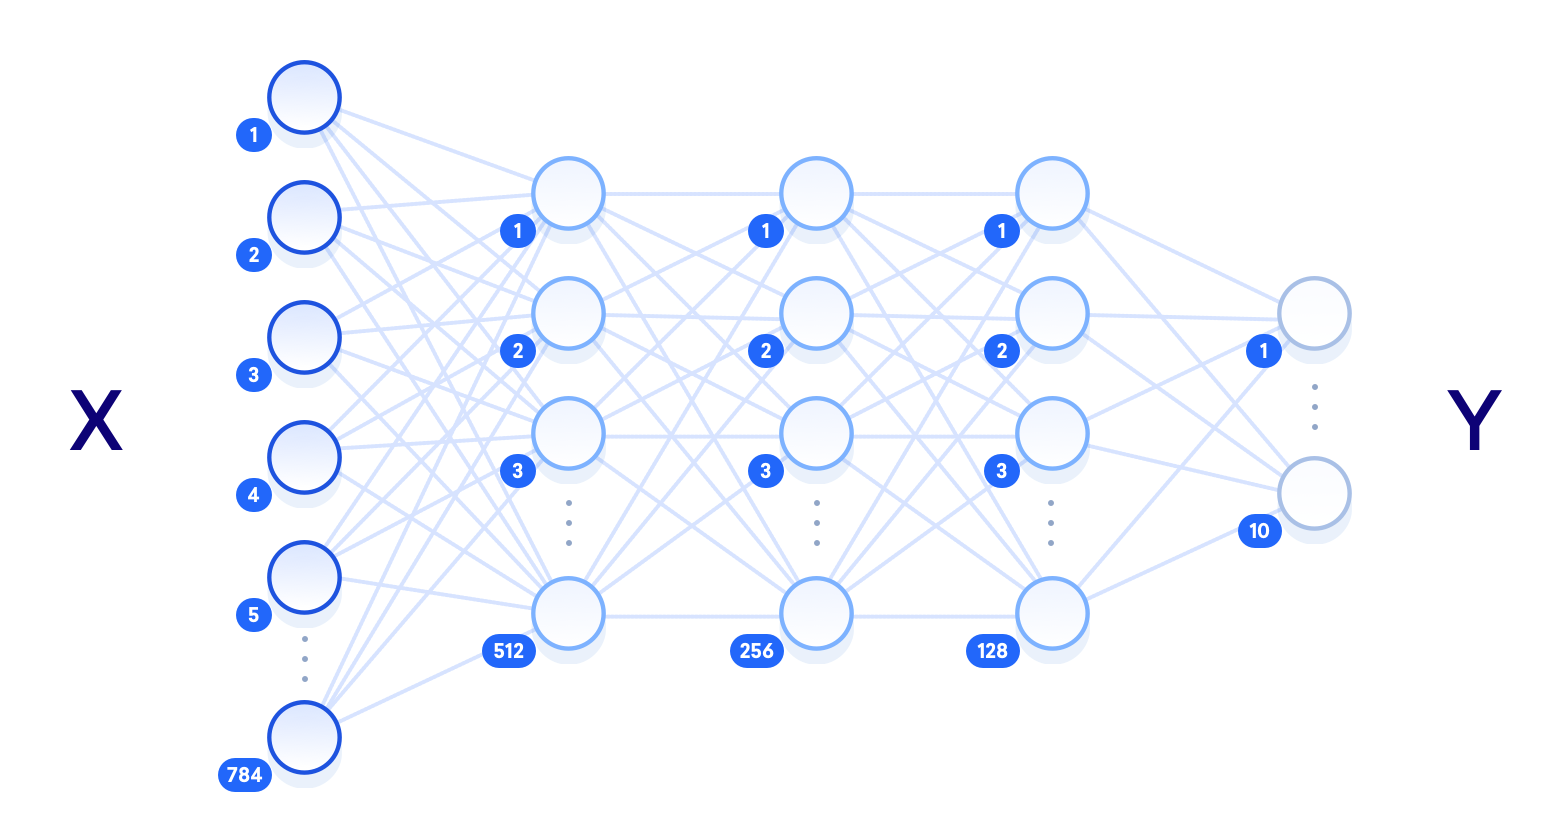

In [61]:
def create_model():
  model=Sequential()
  model.add(Dense(10,input_dim=num_pixels,activation='relu'))
  model.add(Dense(30,activation='relu'))
  model.add(Dense(10,activation='relu'))
  model.add(Dense(num_classes,activation='softmax'))
  model.compile(Adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
  #model.compile(Adam(lr=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

  return model

In [62]:
  model = create_model()
  print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 10)                6490      
                                                                 
 dense_5 (Dense)             (None, 30)                330       
                                                                 
 dense_6 (Dense)             (None, 10)                310       
                                                                 
 dense_7 (Dense)             (None, 10)                110       
                                                                 
Total params: 7240 (28.28 KB)
Trainable params: 7240 (28.28 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


In [63]:
csv_logger=CSVLogger('/content/drive/MyDrive/TrainedModels/MnistANN.log',separator=',',append=False)

In [64]:
num_epochs=1000

In [65]:
history=model.fit(X_train,y_train,validation_split=0.20,epochs=num_epochs,batch_size=128,verbose=1)

Epoch 1/1000
4/4 [==============================] - 2s 88ms/step - loss: 2.3026 - accuracy: 0.0825 - val_loss: 2.3028 - val_accuracy: 0.0900
Epoch 2/1000
4/4 [==============================] - 0s 17ms/step - loss: 2.3018 - accuracy: 0.1525 - val_loss: 2.3030 - val_accuracy: 0.0700
Epoch 3/1000
4/4 [==============================] - 0s 21ms/step - loss: 2.3013 - accuracy: 0.1150 - val_loss: 2.3034 - val_accuracy: 0.0700
Epoch 4/1000
4/4 [==============================] - 0s 24ms/step - loss: 2.3006 - accuracy: 0.1375 - val_loss: 2.3036 - val_accuracy: 0.0900
Epoch 5/1000
4/4 [==============================] - 0s 17ms/step - loss: 2.3001 - accuracy: 0.1400 - val_loss: 2.3040 - val_accuracy: 0.0900
Epoch 6/1000
4/4 [==============================] - 0s 21ms/step - loss: 2.2997 - accuracy: 0.1400 - val_loss: 2.3042 - val_accuracy: 0.0900
Epoch 7/1000
4/4 [==============================] - 0s 16ms/step - loss: 2.2993 - accuracy: 0.1400 - val_loss: 2.3045 - val_accuracy: 0.0900
Epoch 8/1000


In [67]:
model.save('/content/drive/MyDrive/TrainedModels/MnistANN.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [68]:
model2=load_model('/content/drive/MyDrive/TrainedModels/MnistANN.h5')

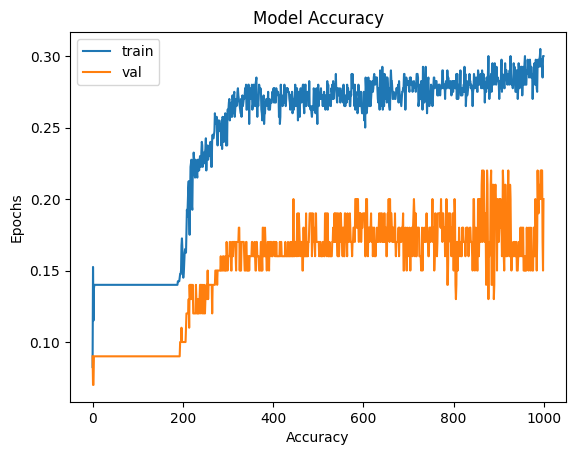

In [69]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Accuracy')
plt.ylabel('Epochs')
plt.legend(['train','val'])

In [70]:
y_pred_hot=(model.predict(X_test)>0.5)*1
#y_pred = [int(y) for y in y_pred]
print(y_pred_hot.shape)
print(y_test.shape)
print(y_test[1])
print(y_pred_hot[1])

16/16 [==============================] - 0s 2ms/step
(500, 10)
(500, 1)
[8]
[0 0 0 0 0 0 0 0 0 0]


In [71]:
y_test_hot = np.zeros((y_test.shape[0], y_test.max()+1), dtype=np.float32)
y_test_hot[np.arange(y_test.shape[0]), y_test] = 1
print(y_test_hot.shape)
print(y_test_hot[1])
print(y_pred_hot[1])



(500, 10)
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0 0 0 0 0 0 0 0 0 0]


In [72]:
#test_eval=model.evaluate(X_test,y_test, verbose=0)
test_eval = model.evaluate(X_test, y_test_hot, batch_size=128)
print("Test Accuracy: ",test_eval[1])

4/4 [==============================] - 0s 4ms/step - loss: 32.2281 - accuracy: 0.0120
Test Accuracy:  0.012000000104308128


In [73]:
y_pred = (np.argmax(y_pred_hot, axis=1)+1).reshape(-1, 1)
print(y_pred)

[[1]
 [1]
 [2]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [2]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]
 [1]


In [74]:
print(y_test_hot[10])
print(y_pred[10])
from sklearn.metrics import confusion_matrix
from sklearn.metrics import multilabel_confusion_matrix
cm=confusion_matrix(y_test,y_pred)
#cm=multilabel_confusion_matrix(y_test_hot,y_pred) #actual , and predicted
cm

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1]


array([[ 0, 56,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 35,  6,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 50,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 49,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 40,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 48,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 54,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 47,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 56,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 55,  1,  0,  0,  0,  0,  0,  0,  0]])

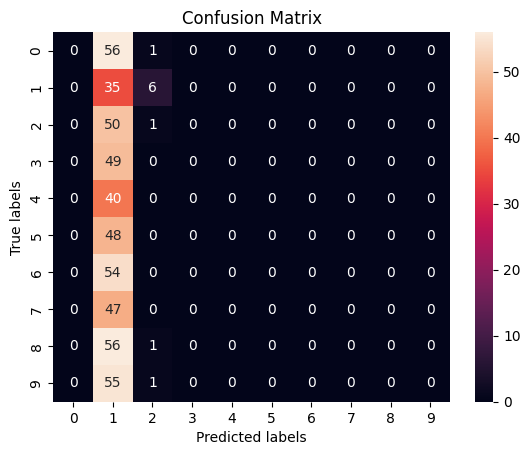

In [75]:
import seaborn as sns
ax= plt.subplot()

sns.heatmap(cm,annot=True,fmt='g',ax=ax)

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
ax.set_title('Confusion Matrix');

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# Convert one-hot encoded labels back to a single column
y_train_true = np.argmax(y_train, axis=1)
y_test_true = np.argmax(y_test, axis=1)

# Predictions for the training set
y_train_pred_hot = model.predict(X_train)
y_train_pred = np.argmax(y_train_pred_hot, axis=1)

# Predictions for the test set
y_test_pred_hot = model.predict(X_test)
y_test_pred = np.argmax(y_test_pred_hot, axis=1)

# Accuracy
train_accuracy = accuracy_score(y_train_true, y_train_pred)
test_accuracy = accuracy_score(y_test_true, y_test_pred)

# Precision
train_precision = precision_score(y_train_true, y_train_pred, average='weighted')
test_precision = precision_score(y_test_true, y_test_pred, average='weighted')

# Recall
train_recall = recall_score(y_train_true, y_train_pred, average='weighted')
test_recall = recall_score(y_test_true, y_test_pred, average='weighted')

print("Training Accuracy:", train_accuracy)
print("Test Accuracy:", test_accuracy)

print("Training Precision:", train_precision)
print("Test Precision:", test_precision)

print("Training Recall:", train_recall)
print("Test Recall:", test_recall)

#ANN from Scratch

# Activation Function
In the hidden layer, we will use the tanh activation function and in the output layer, I will use the sigmoid function. It is easy to find information on both the sigmoid function and the tanh function graph. I don’t want to bore you with explanations, so I will just implement it.

In [32]:
def sigmoid(x):
    return (1 / (1 + np.exp(-x)))

# Setting Parameters
What are parameters and hyperparameters? Parameters are weights and biases. Hyperparameters effect parameters and are before the learning begins. Setting hyperparameters perfectly correctly at first is not a piece of cake, you’ll need to tinker and tweak your values. The learning rate, number of iterations, and regularization rate, among others, can all be considered as hyperparameters.
Wondering how to set the matrices sizes? The answer just below!
![Setting parameters](https://i.ibb.co/6tLhtbM/1-3-MP-7v-Gy-Nt7np-C-69z-JI9g.png)
What does all that mean? For example:
* (layer 0 so L = 0) number of neurons in input layers = 3
* (layer 1 so L = 1) number of neurons in hidden layers = 5
* (layer 2 so L = 2) number of neurons in output layers = 1
![Example](https://i.ibb.co/W2t1zWS/1-LSMk-P5-YLdb8q-Uv9-QP18-Ky-Q.png)
I hope this all makes sense! Let’s set the parameters:

In [33]:
#This is just the test code to understand the number of indices required for A[i]
no_hidden_layers = 1
W_test = [-1]
b_test = [-1]
for i in range (0, no_hidden_layers):
   W_test.append([[1,1,1],[2,2,2]])
   b_test.append([1,2,3])
W_test.append([[3,3,3],[4,4,4]])
b_test.append([5,6,7])
for i in range (0, no_hidden_layers + 2):
   print('W[',i,'] = ', W_test[i])
   print('b[',i,'] = ', b_test[i])
print(np.shape(W_test))

W[ 0 ] =  -1
b[ 0 ] =  -1
W[ 1 ] =  [[1, 1, 1], [2, 2, 2]]
b[ 1 ] =  [1, 2, 3]
W[ 2 ] =  [[3, 3, 3], [4, 4, 4]]
b[ 2 ] =  [5, 6, 7]
(3,)


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:2009: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


# Part 2

Initialize wight and bias matrices for each hidden layer

In [34]:
def setParameters(X, Y, hidden_size, no_hidden_layers):
    np.random.seed(3)
    W = [-1]  # Declare W with dummy values for the first row, so that weights start from W[1]
    b = [-1]  # Declare b with dummy values for the first row so that bias starts from b[1]

    input_size = X.shape[0]  # number of neurons in the input layer
    output_size = Y.shape[0]  # number of neurons in the output layer.
    size_R = hidden_size  # Size of the output layer for the current weight
    size_L = input_size  # Size of the input layer for the current weight

    for i in range(0, no_hidden_layers):
        # Initialize weight and bias matrices for each hidden layer
        W.append(np.random.randn(size_R, size_L) * np.sqrt(1 / size_L))
        b.append(np.zeros((size_R, 1)))

        size_L = size_R  # It is assumed that the size of all the hidden layers is the same
    print('i: ', i)
    # Initialize weight and bias matrices for the final layer
    W.append(np.random.randn(output_size, size_L) * np.sqrt(1 / size_L))
    b.append(np.zeros((output_size, 1)))

    return {'W': W, 'b': b}


In [35]:
#Testing setParameters
X = np.array([1, 2, 3, 4])
Y = np.array([1, 2, 3])
params = setParameters(X, Y, 5, 1)
W = params['W']
b = params['b']
print(np.shape(b[0]))
print(np.shape(W[0]))
print(np.shape(b[1]))
print(np.shape(W[1]))



i:  0
()
()
(5, 1)
(5, 4)


We define Ws and bs. It doesn’t hurt if you set your biases to zero at first. However, be very careful when initializing weights. Never set the weights to zero at first. Why exactly? Well, if you do, then in Z = Wx + b, Z will always be zero. If you are building a multi-layer neural network, neurons in every layer will behave like there is one neuron. So how do we initialize weights at first? I use Xavier initialization.
![](https://i.ibb.co/H7XfnmV/1-x-Y0t-FMVjwdo-JQs8x9by-J1-Q.png)

In [ ]:
# Python implementation
# np.random.randn(output_size, hidden_size)*np.sqrt(1/hidden_size)

You don’t have to use Xavier initialization, you can also use this:

In [ ]:
# np.random.randn(output_size, hidden_size)*0.01

It's recommended to never set weights to zero or a big number when initializing parameters.

# Forward Propagation
![](https://i.ibb.co/fSDbWFR/1-m-O1-O1o-Usu9-Fk-YK-81-DPf-TQ.png)
The diagram above should give you a good idea of what forward propagation is. The implementation in Python is:

# Part 3

Calculate the values of Z and A for each layer in the forward propagation

In [36]:
def forwardPropagation(X, parameters, no_hidden_layers):
    W = parameters["W"]
    b = parameters["b"]

    Z = [-1]
    A = []
    A.append(X)

    for i in range(0, no_hidden_layers + 1):
        # Calculate the values of Z and A for each layer
        Z.append(np.dot(W[i + 1], A[i]) + b[i + 1])
        A.append(sigmoid(Z[i + 1]))

    y = sigmoid(Z[no_hidden_layers + 1])

    return y, {'Z': Z, 'A': A, 'y': y}



Why we are storing {‘Z1’: Z1, ‘Z2’: Z2, ‘A1’: A1, ‘y’: y}? Because we will use them when back-propagating.

![](https://i.ibb.co/fvMVmwv/1-a-Kn-E6-Em-YIn-Ho-SQe-Yxbk86g.png)
![](https://i.ibb.co/XymnY9w/1-k-AU9-URu-Nx-T9v-A4-CGPw-ZYUw.png)

We update our parameters and find the best parameter that gives us the minimum possible cost. I’m not going to delve into derivatives, but note that on the graph above, if you are on the right sight of the parabola, the derivative (slope) will be positive, so the parameter will decrease and move left approaching the parameter that returns the minimum cost. On the left side, the slope will be negative, so the parameter increases towards the value we want. Let’s look at the cost function we will use:

![](https://i.ibb.co/pRXSfLx/1-T7-U1-JGo-Tlw3oc-Tb-Y-1-TTeg.png)

Python code for cost function:

In [37]:
def cost(predict, actual):
    print('predict: ', predict)
    print('actual: ', actual)
    print('predict.shape: ', predict.shape)
    print('cost - actual.shape: ', actual.shape)

    m = actual.shape[1]
    cost__ = -np.sum(np.multiply(np.log(predict), actual) + np.multiply((1 - actual), np.log(1 - predict)))/m
    return np.squeeze(cost__)


# Backpropagation
We’ve found the cost, now let’s go back and find the derivative of our weights and biases.

# Part 4

a) Calculate the values of dW, db and dZ for each layer of the backpropagation
b) Fill in the indices of A[] and W[] with appropriate values for each layer
 of the backward propagation (including the first layer) in the backward direction

In [38]:
def backPropagate_OneLayer(A, W, dZ, m, first_layer):
    dW = np.dot(dZ, A.T) / m
    db =  db = np.sum(dZ, axis=1, keepdims=True) / m

    if not first_layer:
        dZ = np.dot(W.T, dZ) * (1 - A) * A

    return dW, db, dZ

def backPropagation(X, Y, no_hidden_layers, params, cache):
    N_hl = no_hidden_layers
    W = params['W']
    A = cache['A']
    m = X.shape[1]
    dy = cache['y'] - Y
    dZ = dy
    dW = []
    db = []

    for i in range(N_hl, 0, -1):
        print(f"Layer {i}:")
        print(f"dZ shape: {dZ.shape}")
        print(f"A shape: {A[i].shape}")
        dW_, db_, dZ = backPropagate_OneLayer(A[i], W[i + 1], dZ, m, False)
        print(f"dW shape: {dW_[0].shape}")
        print(f"db shape: {db_[0].shape}")
        dW.insert(0, dW_)
        db.insert(0, db_)

    print("Output Layer:")
    print(f"dZ shape: {dZ.shape}")
    dW_, db_, dZ = backPropagate_OneLayer(A[0], W[1], dZ, m, False)
    print(f"dW shape: {dW_[0].shape}")
    print(f"db shape: {db_[0].shape}")
    dW.insert(0, dW_)
    db.insert(0, db_)

    return {"dW": dW, "db": db}




##### What are the params and cache in def backPropagation(X, Y, params, cache)? When we use forward propagation, we store values to use during backpropagation. Params are parameters (weight and biases).

# Updating Parameters
Now that we have our derivatives, we can use the equation below:
![](https://i.ibb.co/XymnY9w/1-k-AU9-URu-Nx-T9v-A4-CGPw-ZYUw.png)
In that equation, alpha (α) is the learning rate hyperparameter. We need to set it to some value before the learning begins. The term to the right of the learning rate is the derivative. We know alpha and derivatives, let’s update our parameters.

# Part 5

Update the values of W and b for each layer

In [39]:
def updateParameters(no_hidden_layers, gradients, params, learning_rate=1.2):
    W = params['W']
    b = params['b']
    db = gradients['db']
    dW = gradients['dW']

    for i in range(1, no_hidden_layers + 2):
        # Update the values of W and b for the current hidden layer
        W[i] -= learning_rate * dW[i - 1]
        b[i] -= learning_rate * db[i - 1]

    return {'W': W, 'b': b}


All About Loops¶
We need to run many interations to find the parameters that return the minimum cost. Let’s loops it!

In [40]:
def fit(X, Y, learning_rate, hidden_size, no_hidden_layers, number_of_iterations = 5000):
    params = setParameters(X, Y, hidden_size, no_hidden_layers)
    cost_ = []
    for j in range(number_of_iterations):
        print('Iteration# ', j)
        y, cache = forwardPropagation(X, params, no_hidden_layers)
        print('Line 1')
        costit = cost(y, Y)
        print('Line 2')
        gradients = backPropagation(X, Y, no_hidden_layers, params, cache)
        print('Line 3')
        params = updateParameters(no_hidden_layers, gradients, params, learning_rate)
        cost_.append(costit)
        print('Cost after iteration {}: {}'.format(j, costit))
        print('Shape of W[1]:', params['W'][1].shape)
        print('Shape of A[0]:', cache['A'][0].shape)
        print('Shape of A[1]:', cache['A'][1].shape)
    return params, cost_

In [41]:
# GRADED FUNCTION: predict

def predict(X, params, no_hidden_layers):
    '''
    Predict whether the label is 0 or 1 using learned logistic regression parameters (w, b)

    Arguments:
    w -- weights, a numpy array of size (num_px * num_px * 3, 1)
    b -- bias, a scalar
    X -- data of size (num_px * num_px * 3, number of examples)

    Returns:
    Y_prediction -- a numpy array (vector) containing all predictions (0/1) for the examples in X
    '''
    m = X.shape[1]
    #print('m in predict function: ', m)
    Y_prediction = np.zeros((1, m))
    Y, cache = forwardPropagation(X, params, no_hidden_layers)
    for i in range(Y.shape[1]):

        # Convert probabilities A[0,i] to actual predictions p[0,i]
        if Y[0, i] > 0.5:
            Y_prediction[0,i] = 1
        else:
            Y_prediction[0,i] = 0
        # YOUR CODE ENDS HERE

    return Y_prediction.reshape((1, m))

Hidden_size means the number of neurons in the hidden layer. It looks like a hyperparameter. Because you set it before learning begins! What return params, cost_ tells us. params are the best parameters we found and cost_ is just cost we estimated in every episode.

# Let’s Try Our Code!
Use [sklearn](https://scikit-learn.org/stable/?source=post_page---------------------------) to create a dataset.

In [42]:
import sklearn.datasets
X, Y = sklearn.datasets.make_moons(n_samples=500, noise=0.2)
print(Y.shape)
X, Y = X.T, Y.reshape(1, Y.shape[0])
print(Y.shape)

(500,)
(1, 500)


In [43]:
X_train.shape[1]

324

In [44]:
# X = X.reshape(1, -1)
# X = X[0:500]
X.shape
# X = X[:, :500]
# print(X.shape)

(2, 500)

In [45]:
params, cost_ = fit(X, Y, 0.3, 10, 1, 5000)

Streaming output truncated to the last 5000 lines.
  2.33636757e-02 6.08058767e-02 9.90492323e-01 9.61209342e-04
  9.95900960e-01 1.00221709e-01 9.84294053e-01 9.53029302e-03
  8.96465828e-01 4.26732158e-02 4.43533685e-02 9.74407222e-01
  7.39025034e-01 1.05813371e-01 2.66324848e-03 6.67797599e-01
  9.89812602e-01 9.96292678e-01 9.73068157e-01 5.60723977e-02
  5.79067469e-03 1.89732959e-02 9.56627231e-01 2.17706097e-02
  9.54120392e-01 1.54711094e-01 9.98895065e-01 6.84015357e-02
  1.17957634e-01 8.24806577e-02 9.97798865e-01 2.75910667e-02
  9.53876171e-01 3.28553890e-02 9.41748154e-01 5.19575120e-02
  9.02961664e-01 2.85190233e-03 1.11866183e-02 6.18249130e-02
  1.70820216e-02 1.08908320e-03 9.63741189e-01 1.07458988e-01
  8.71641736e-01 3.72282998e-02 9.90765188e-01 1.05325481e-01
  2.90683704e-01 7.74638780e-02 9.75260865e-01 1.47465022e-02
  9.69946372e-01 7.53500415e-01 9.69310170e-01 1.42921346e-02
  1.52186487e-03 1.51426568e-02 1.30583609e-01 4.21048565e-02
  9.37777383e-01 9.

I set the learning rate to 0.3, the number of neurons in the hidden layer to 5 and the number of iterations to 5000. Feel free to try with different values. Let’s draw a graph showing how the cost function changed with every episode:

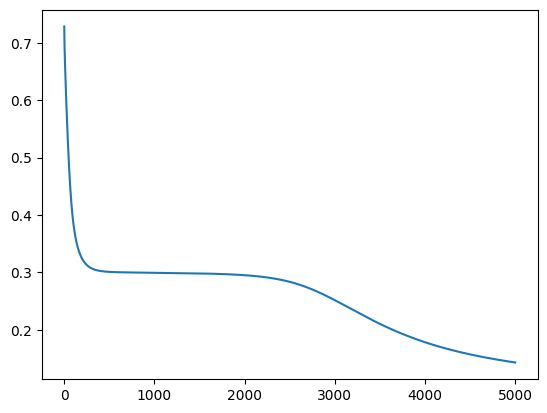

In [46]:
import matplotlib.pyplot as plt
plt.plot(cost_)

In [47]:
# GRADED FUNCTION: model

def model(X_train, Y_train, X_test, Y_test, hidden_size = 10, no_hidden_layers = 1, num_iterations=2000, learning_rate=0.5, print_cost=False):
    """
    Builds the logistic regression model by calling the function you've implemented previously

    Arguments:
    X_train -- training set represented by a numpy array of shape (num_px * num_px * 3, m_train)
    Y_train -- training labels represented by a numpy array (vector) of shape (1, m_train)
    X_test -- test set represented by a numpy array of shape (num_px * num_px * 3, m_test)
    Y_test -- test labels represented by a numpy array (vector) of shape (1, m_test)
    num_iterations -- hyperparameter representing the number of iterations to optimize the parameters
    learning_rate -- hyperparameter representing the learning rate used in the update rule of optimize()
    print_cost -- Set to True to print the cost every 100 iterations

    Returns:
    d -- dictionary containing information about the model.
    """
    print("model function - X_train.shape: ", X_train.shape)
    print("model function - X_test.shape", X_test.shape)

    parameters, costs = fit(X_train, Y_train, learning_rate, hidden_size, no_hidden_layers, num_iterations)
    Y_prediction_test = predict(X_test, parameters, no_hidden_layers)
    Y_prediction_train = predict(X_train, parameters, no_hidden_layers)

    W = parameters["W"]
    b = parameters["b"]

    print("model function - W[1].shape: ", W[1].shape)
    print("model function - W[2].shape: ", W[2].shape)

    # Print train/test Errors
    if print_cost:
        print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - Y_train)) * 100))
        print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - Y_test)) * 100))


    d = {"costs": costs,
         "Y_prediction_test": Y_prediction_test,
         "Y_prediction_train" : Y_prediction_train,
         "W" : W,
         "b" : b,
         "learning_rate" : learning_rate,
         "num_iterations": num_iterations}

    return d

In [ ]:
XTrain=X_train.T
XTest=X_test.T
yTrain =y_train.T
yTest =y_test.T

In [ ]:
LR__model = model(XTrain,yTrain,XTest,yTest, hidden_size = 10, no_hidden_layers = 1, num_iterations=400, learning_rate=0.005, print_cost=True)

Streaming output truncated to the last 5000 lines.
dZ shape: (10, 500)
A shape: (10, 500)
dW shape: (10,)
db shape: (1,)
Output Layer:
dZ shape: (10, 500)
dW shape: (3072,)
db shape: (1,)
Line 3
Cost after iteration 248: 3.971138123777708
Shape of W[1]: (10, 3072)
Shape of A[0]: (3072, 500)
Shape of A[1]: (10, 500)
Iteration#  249
Line 1
predict:  [[0.2612967  0.26128793 0.26120158 ... 0.26126048 0.26128148 0.26125524]
 [0.23790391 0.23796305 0.23802067 ... 0.23799812 0.23797017 0.23793889]
 [0.23978642 0.2397895  0.23974676 ... 0.23975994 0.23978977 0.23971187]
 ...
 [0.22415151 0.22411714 0.22406194 ... 0.22407565 0.22415866 0.22404637]
 [0.22393536 0.22394111 0.22387687 ... 0.22385709 0.2239377  0.22385527]
 [0.30918305 0.30926751 0.30926428 ... 0.30927381 0.30918439 0.30924162]]
actual:  [[0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]]
predict.shape:  (10, 500)
cost - actual.s

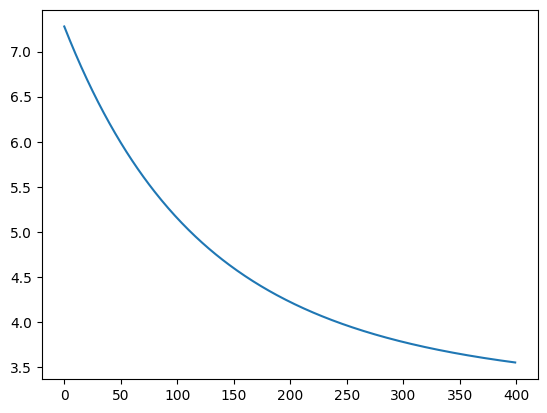

In [ ]:
import matplotlib.pyplot as plt
costs = LR__model['costs']
plt.plot(costs)